# 전체적으로 사용되는 함수 및 변수 정의하기

In [4]:
hifi_dir = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData/hifi'
grayscaled_lofi_dir = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData/grayscaled_lofi'
styled_lofi_dir = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData/styled_lofi'
sketch_image_dir = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData/sketch_image'
grayscaled_model_gen_weight_file = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData/grayscaled_model_gen.pt'
grayscaled_model_dis_weight_file = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData/grayscaled_model_dis.pt'
styled_model_gen_weight_file = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData/styled_model_gen.pt'
styled_model_dis_weight_file = '/content/drive/MyDrive/Colab Notebooks/Github/IndividualProjcet-lofiToHifi/MyData/styled_model_dis.pt'

# 자료 저장할 폴더 만들기
def create_dir(name):
    if not os.path.isdir(name):
        os.makedirs(name)

# 웹 크롤링 및 데이터 저장하기
---
- https://pgh268400.tistory.com/286
- https://velog.io/@jungeun-dev/Python-%EC%9B%B9-%ED%81%AC%EB%A1%A4%EB%A7%81Selenium-%EA%B5%AC%EA%B8%80-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%88%98%EC%A7%91
- https://blog.naver.com/PostView.nhn?blogId=jinyuri303&logNo=222268855640&categoryNo=39&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView
- https://swlock.blogspot.com/2021/10/python-count-files.html

In [ ]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import time
import os
import requests
from PIL import Image
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver import ActionChains

In [3]:
# 특정 키워드로 검색한 구글 이미지들을 저장
def get_images_from_web(keyword, dir_name):

    #Colab에선 웹브라우저 창이 뜨지 않으므로 별도 설정한다.
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome('chromedriver', options=options)
    
    # 구글 이미지 검색창으로 이동
    url = "https://www.google.co.kr/imghp?hl=ko" 
    driver.get(url)

    # 해당 키워드 검색하기
    search_box = driver.find_element(By.NAME, 'q')
    search_box.send_keys(keyword)
    search_box.send_keys(Keys.ENTER)

    # 처음에는 일부 이미지만 보여지기 때문에, 스크롤을 내려서 더 불러오기
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") 
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            try:
                driver.find_element(By.CSS_SELECTOR, ".mye4qd").click()
            except:
                break
        last_height = new_height

    # 폴더 만들고 이미지 저장하기
    create_dir(dir_name)
    imgs = driver.find_elements(By.CSS_SELECTOR, ".rg_i.Q4LuWd")
    actions = ActionChains(driver)

    count = 1
    for i, img in enumerate(imgs):
        print("\r" + str(i+1) + "/" + str(len(imgs)), end='  ')
        try:
            actions.move_to_element(img).click().perform()
            time.sleep(2)
            img_url = driver.find_element(By.CSS_SELECTOR, ".n3VNCb.KAlRDb").get_attribute('src')
            file_path = dir_name + '/img' + str(count) + '.jpg'
            req = requests.get(img_url)
            with open(file_path, 'wb') as outfile:
                outfile.write(req.content)
            count += 1
        except:
            print('fail')
            pass

    driver.close()

In [ ]:
# 라벨로 사용할 앱 디자인 관련 이미지 크롤링하기
get_images_from_web(keyword='app design', dir_name=hifi_dir)
# 스타일을 추출할 스케치 관련 이미지 크롤링하기
get_images_from_web(keyword='sketch', dir_name=sketch_image_dir)

# 흑백으로 바꾼 이미지 저장하기
---
- https://www.delftstack.com/ko/howto/python/convert-image-to-grayscale-python/

In [ ]:
create_dir(grayscaled_lofi_dir)
files = os.listdir(hifi_dir)
files_cnt = len(files)
for i, filename in enumerate(files):
    print("\r" + str(i+1) + "/" + str(files_cnt), end='  ')
    try:
        img = Image.open(hifi_dir+'/'+filename)
        file_path = grayscaled_lofi_dir + '/img' + filename[3:]
        img.convert('L').save(file_path)
    except:
        print('fail')
        pass

# Sketch 효과 적용한 이미지 저장하기
---
- https://www.tensorflow.org/tutorials/generative/style_transfer?hl=ko

In [3]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import PIL.Image
import os

def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')

create_dir(styled_lofi_dir)
files = os.listdir(hifi_dir)
files_cnt = len(files)
for i, filename in enumerate(files):
    print("\r" + str(i+1) + "/" + str(files_cnt), end='  ')
    try:
        content_image = load_img(hifi_dir+'/'+filename)
        style_image = load_img(sketch_image_dir + '/img3.jpg')

        stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
        img = tensor_to_image(stylized_image)
        file_path = styled_lofi_dir + '/' + filename
        img.save(file_path)
    except:
        print('fail')
        pass

10/764  fail
92/764  fail
99/764  fail
101/764  fail
113/764  fail
122/764  fail
125/764  fail
130/764  fail
134/764  fail
137/764  fail
143/764  fail
145/764  fail
152/764  fail
165/764  fail
166/764  fail
172/764  fail
201/764  fail
204/764  fail
222/764  fail
267/764  fail
269/764  fail
284/764  fail
293/764  fail
297/764  fail
302/764  fail
306/764  fail
312/764  fail
316/764  fail
318/764  fail
325/764  fail
332/764  fail
334/764  fail
342/764  fail
343/764  fail
345/764  fail
347/764  fail
356/764  fail
359/764  fail
366/764  fail
373/764  fail
376/764  fail
387/764  fail
403/764  fail
405/764  fail
409/764  fail
411/764  fail
415/764  fail
432/764  fail
437/764  fail
440/764  fail
477/764  fail
494/764  fail
495/764  fail
506/764  fail
512/764  fail
524/764  fail
525/764  fail
526/764  fail
540/764  fail
541/764  fail
542/764  fail
557/764  fail
559/764  fail
568/764  fail
573/764  fail
595/764  fail
600/764  fail
604/764  fail
606/764  fail
609/764  fail
612/764  fail
614/764  

# 데이터 준비하기
---
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb

In [5]:
import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Costum dataset 생성
class FacadeDataset(Dataset):
    def __init__(self, lofi_dir, transform=False):
        super().__init__()
        self.lofi_dir = lofi_dir
        self.img_filenames = [x for x in os.listdir(self.lofi_dir)]
        self.transform = transform

    def __getitem__(self, index):
        a = Image.open(hifi_dir+'/'+self.img_filenames[index]).convert('RGB')
        b = Image.open(self.lofi_dir+'/'+self.img_filenames[index]).convert('RGB')
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)

        return b,a

    def __len__(self):
        return len(self.img_filenames)

In [7]:
# transforms 정의
transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
                    transforms.Resize((256,256))
])

train_ds_grayscaled = FacadeDataset(grayscaled_lofi_dir, transform=transform)
train_ds_styled = FacadeDataset(styled_lofi_dir, transform=transform)

# 데이터 로더 생성하기
train_dl_grayscaled = DataLoader(train_ds_grayscaled, batch_size=32, shuffle=True)
train_dl_styled = DataLoader(train_ds_styled, batch_size=32, shuffle=True)

(-0.5, 255.5, 255.5, -0.5)

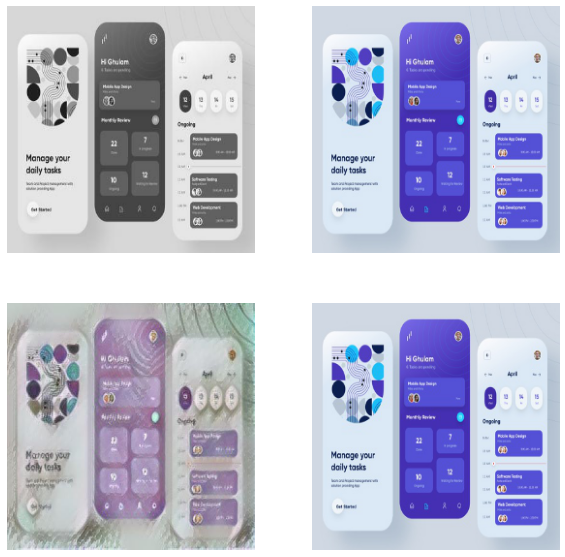

In [8]:
# 샘플 이미지 확인하기
plt.figure(figsize=(10,10))

a,b = train_ds_grayscaled[0]

plt.subplot(2,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

a, b = train_ds_styled[0]

plt.subplot(2,2,3)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(to_pil_image(0.5*b+0.5))
plt.axis('off')

# 모델 구축하기
---
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb

In [9]:
# UNet
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)]

        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels)),

        layers.append(nn.LeakyReLU(0.2))

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        x = self.down(x)
        return x

# check
x = torch.randn(16, 3, 256,256, device=device)
model = UNetDown(3,64).to(device)
down_out = model(x)
print(down_out.shape)

torch.Size([16, 64, 128, 128])


In [10]:
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super().__init__()

        layers = [
            nn.ConvTranspose2d(in_channels, out_channels,4,2,1,bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU()
        ]

        if dropout:
            layers.append(nn.Dropout(dropout))

        self.up = nn.Sequential(*layers)

    def forward(self,x,skip):
        x = self.up(x)
        x = torch.cat((x,skip),1)
        return x

# check
x = torch.randn(16, 128, 64, 64, device=device)
model = UNetUp(128,64).to(device)
out = model(x,down_out)
print(out.shape)

torch.Size([16, 128, 128, 128])


In [11]:
# generator: 가짜 이미지를 생성합니다.
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64,128)                 
        self.down3 = UNetDown(128,256)               
        self.down4 = UNetDown(256,512,dropout=0.5) 
        self.down5 = UNetDown(512,512,dropout=0.5)      
        self.down6 = UNetDown(512,512,dropout=0.5)             
        self.down7 = UNetDown(512,512,dropout=0.5)              
        self.down8 = UNetDown(512,512,normalize=False,dropout=0.5)

        self.up1 = UNetUp(512,512,dropout=0.5)
        self.up2 = UNetUp(1024,512,dropout=0.5)
        self.up3 = UNetUp(1024,512,dropout=0.5)
        self.up4 = UNetUp(1024,512,dropout=0.5)
        self.up5 = UNetUp(1024,256)
        self.up6 = UNetUp(512,128)
        self.up7 = UNetUp(256,64)
        self.up8 = nn.Sequential(
            nn.ConvTranspose2d(128,3,4,stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)

        u1 = self.up1(d8,d7)
        u2 = self.up2(u1,d6)
        u3 = self.up3(u2,d5)
        u4 = self.up4(u3,d4)
        u5 = self.up5(u4,d3)
        u6 = self.up6(u5,d2)
        u7 = self.up7(u6,d1)
        u8 = self.up8(u7)

        return u8

# check
x = torch.randn(16,3,256,256,device=device)
model = GeneratorUNet().to(device)
out = model(x)
print(out.shape)

torch.Size([16, 3, 256, 256])


In [12]:
class Dis_block(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super().__init__()

        layers = [nn.Conv2d(in_channels, out_channels, 3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
    
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.block(x)
        return x

# check
x = torch.randn(16,64,128,128,device=device)
model = Dis_block(64,128).to(device)
out = model(x)
print(out.shape)

torch.Size([16, 128, 64, 64])


In [13]:
# Discriminator은 patch gan을 사용합니다.
# Patch Gan: 이미지를 16x16의 패치로 분할하여 각 패치가 진짜인지 가짜인지 식별합니다.
# high-frequency에서 정확도가 향상됩니다.

class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.stage_1 = Dis_block(in_channels*2,64,normalize=False)
        self.stage_2 = Dis_block(64,128)
        self.stage_3 = Dis_block(128,256)
        self.stage_4 = Dis_block(256,512)

        self.patch = nn.Conv2d(512,1,3,padding=1) # 16x16 패치 생성

    def forward(self,a,b):
        x = torch.cat((a,b),1)
        x = self.stage_1(x)
        x = self.stage_2(x)
        x = self.stage_3(x)
        x = self.stage_4(x)
        x = self.patch(x)
        x = torch.sigmoid(x)
        return x
# check
x = torch.randn(16,3,256,256,device=device)
model = Discriminator().to(device)
out = model(x,x)
print(out.shape)

torch.Size([16, 1, 16, 16])


In [14]:
model_gen = GeneratorUNet().to(device)
model_dis = Discriminator().to(device)

# 가중치 초기화
def initialize_weights(model):
    class_name = model.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)


# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

# 학습하기
---
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb

In [37]:
# 학습 대상
target = 'grayscaled'
# target = 'styled'

# train 데이터로더
if target == 'grayscaled':
    train_dl = train_dl_grayscaled
elif target == 'styled':
    train_dl = train_dl_styled

In [30]:
# 손실함수
loss_func_gan = nn.BCELoss()
loss_func_pix = nn.L1Loss()

# loss_func_pix 가중치
lambda_pixel = 100

# patch 수
patch = (1,256//2**4,256//2**4)

# 최적화 파라미터
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,beta2))

21


In [17]:
# 학습
model_gen.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hist = {'gen':[],
             'dis':[]}

for epoch in range(num_epochs):
    for a, b in train_dl:
        ba_si = a.size(0)

        # real image
        real_a = a.to(device)
        real_b = b.to(device)

        # patch label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si, *patch, requires_grad=False).to(device)

        # generator
        model_gen.zero_grad()

        fake_b = model_gen(real_a) # 가짜 이미지 생성
        out_dis = model_dis(fake_b, real_b) # 가짜 이미지 식별

        gen_loss = loss_func_gan(out_dis, real_label)
        pixel_loss = loss_func_pix(fake_b, real_b)

        g_loss = gen_loss + lambda_pixel * pixel_loss
        g_loss.backward()
        opt_gen.step()

        # discriminator
        model_dis.zero_grad()

        out_dis = model_dis(real_b, real_a) # 진짜 이미지 식별
        real_loss = loss_func_gan(out_dis,real_label)
        
        out_dis = model_dis(fake_b.detach(), real_a) # 가짜 이미지 식별
        fake_loss = loss_func_gan(out_dis,fake_label)

        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()

        loss_hist['gen'].append(g_loss.item())
        loss_hist['dis'].append(d_loss.item())

        batch_count += 1
    print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 0, G_Loss: 56.952614, D_Loss: 0.211058, time: 6.68 min
Epoch: 1, G_Loss: 54.389778, D_Loss: 0.093506, time: 7.37 min
Epoch: 2, G_Loss: 46.999825, D_Loss: 0.066896, time: 8.06 min
Epoch: 3, G_Loss: 40.622803, D_Loss: 0.035635, time: 8.77 min
Epoch: 4, G_Loss: 41.167164, D_Loss: 0.022852, time: 9.46 min
Epoch: 5, G_Loss: 51.129433, D_Loss: 0.013917, time: 10.17 min
Epoch: 6, G_Loss: 38.923279, D_Loss: 0.042230, time: 10.87 min
Epoch: 7, G_Loss: 41.074833, D_Loss: 1.310324, time: 11.58 min
Epoch: 8, G_Loss: 44.149170, D_Loss: 0.076862, time: 12.28 min
Epoch: 9, G_Loss: 40.040325, D_Loss: 0.083507, time: 12.99 min
Epoch: 10, G_Loss: 33.415100, D_Loss: 0.097632, time: 13.68 min
Epoch: 11, G_Loss: 37.289738, D_Loss: 0.029532, time: 14.39 min
Epoch: 12, G_Loss: 36.890362, D_Loss: 0.180694, time: 15.09 min
Epoch: 13, G_Loss: 33.784214, D_Loss: 0.062394, time: 15.79 min
Epoch: 14, G_Loss: 40.548637, D_Loss: 0.036973, time: 16.49 min
Epoch: 15, G_Loss: 30.712069, D_Loss: 0.030473, time: 1

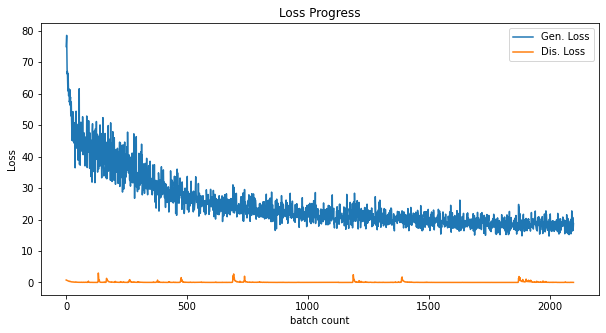

In [18]:
# loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_hist['gen'], label='Gen. Loss')
plt.plot(loss_hist['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# 가중치 저장
if target == 'grayscaled':
    torch.save(model_gen.state_dict(), grayscaled_model_gen_weight_file)
    torch.save(model_dis.state_dict(), grayscaled_model_dis_weight_file)
elif target == 'styled':
    torch.save(model_gen.state_dict(), styled_model_gen_weight_file)
    torch.save(model_dis.state_dict(), styled_model_dis_weight_file)

# 가짜 이미지 확인하기
---
- https://github.com/Seonghoon-Yu/AI_Paper_Review/blob/master/GAN/pix2pix(2016).ipynb

In [38]:
# 가중치 불러오기
if target == 'grayscaled':
    weights = torch.load(grayscaled_model_gen_weight_file)
elif target == 'styled':
    weights = torch.load(styled_model_gen_weight_file)
model_gen.load_state_dict(weights)

<All keys matched successfully>

In [39]:
# evaluation model
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_dl:
        fake_imgs = model_gen(a.to(device)).detach().cpu()
        origin_imgs = a
        real_imgs = b
        break

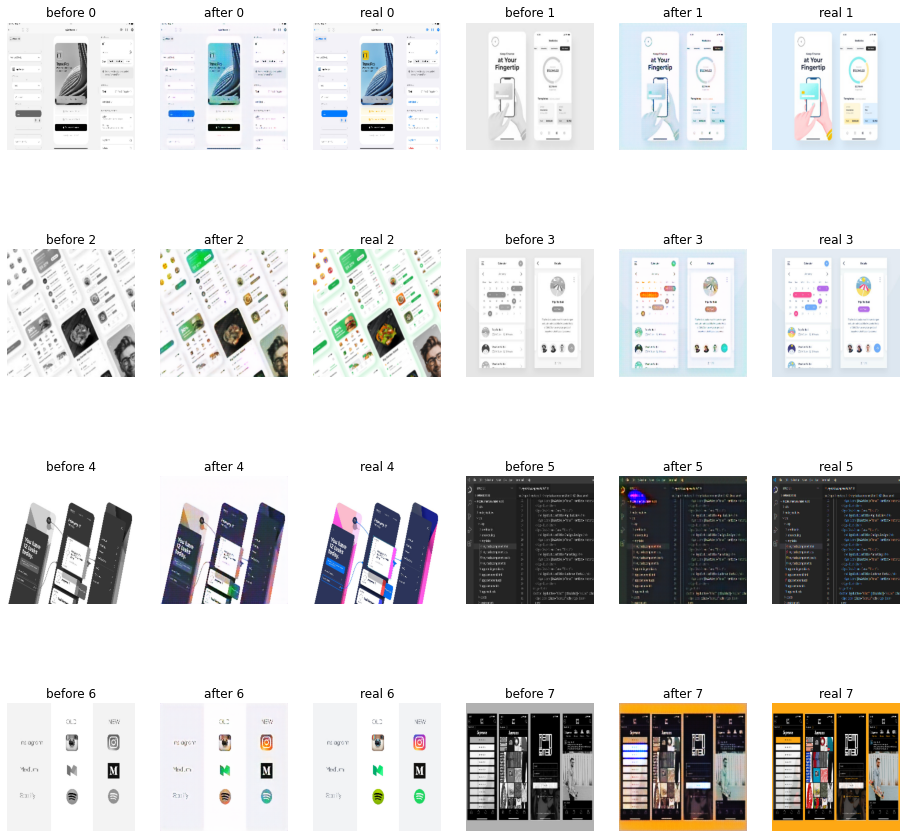

In [40]:
# 가짜 이미지 시각화
plt.figure(figsize=(16,16))

for i in range(0,24,3):

    plt.subplot(4,6,i+1)
    plt.imshow(to_pil_image(0.5*origin_imgs[i]+0.5))
    plt.axis('off')
    plt.title('before ' + str(i//3))

    plt.subplot(4,6,i+2)
    plt.imshow(to_pil_image(0.5*fake_imgs[i]+0.5))
    plt.axis('off')
    plt.title('after ' + str(i//3))

    plt.subplot(4,6,i+3)
    plt.imshow(to_pil_image(0.5*real_imgs[i]+0.5))
    plt.axis('off')
    plt.title('real ' + str(i//3))

# 깃허브 관련

취소 관련   
https://gmlwjd9405.github.io/2018/05/25/git-add-cancle.html

In [ ]:
cd drive/MyDrive/Colab\ Notebooks/Github/IndividualProjcet-lofiToHifi

In [3]:
!git config --global user.email "lightcloud98@gmail.com"
!git config --global user.name "ddophi98"

In [6]:
!git add LoFi_To_HiFi.ipynb

In [ ]:
!git status

In [ ]:
!git commit -m "styled transfer 적용하기 위한 준비"

In [ ]:
!git log

In [ ]:
!git push -u origin main